In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Add the fourier_learning_ibm package to the path
import sys, pprint

sys.path.append("/home/jovyan/fourier_learning_ibm/")
pprint.pprint(sys.path)

['/home/jovyan',
 '/opt/conda/lib/python311.zip',
 '/opt/conda/lib/python3.11',
 '/opt/conda/lib/python3.11/lib-dynload',
 '',
 '/opt/conda/lib/python3.11/site-packages',
 '/home/jovyan/fourier_learning_ibm/']


In [3]:
from pycaret.regression import RegressionExperiment, add_metric
import pickle
import json
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from pycaret.regression import RegressionExperiment

from heisenberg_graph import (
    extract_probs,
)

In [4]:
# Only for CP1
%cd fourier_learning_ibm/

/home/jovyan/fourier_learning_ibm


In [5]:
# Load parameters
CURRENT_TIME = "2024-12-10T15:41Z"
path = f"./data/{CURRENT_TIME}"

# Load the graphs as a binary file
with open(f"{path}/params_object.pkl", "rb") as f:
    params_object = pickle.load(f)

graphs = params_object["graphs"]
all_Js = params_object["Js"]
all_expected_values = params_object["expected_values"]

for key, value in params_object.items():
    print(f"{key}: {value}")

# Load the parameters as a JSON file
with open(f"{path}/params_text.json", "r") as f:
    params = json.load(f)

n_samples = params["n_samples"]
n_qubits = params["n_qubits"]
graph_type = params["graph_type"]
backend_qpu_name = params["backend_qpu_name"]
beta = params["beta"]
C = params["C"]
n_features = params["n_features"]
times = params["times"]

for key, value in params.items():
    print(f"{key}: {value}")

graphs: [<networkx.classes.graph.Graph object at 0x7fb23e245710>, <networkx.classes.graph.Graph object at 0x7fb23e246550>, <networkx.classes.graph.Graph object at 0x7fb23e247110>, <networkx.classes.graph.Graph object at 0x7fb23e247cd0>, <networkx.classes.graph.Graph object at 0x7fb23e24c8d0>, <networkx.classes.graph.Graph object at 0x7fb23e24d490>, <networkx.classes.graph.Graph object at 0x7fb23e24e050>, <networkx.classes.graph.Graph object at 0x7fb23e24ec10>, <networkx.classes.graph.Graph object at 0x7fb23e24f7d0>, <networkx.classes.graph.Graph object at 0x7fb23e25c3d0>, <networkx.classes.graph.Graph object at 0x7fb23e25cf90>, <networkx.classes.graph.Graph object at 0x7fb23e25db50>, <networkx.classes.graph.Graph object at 0x7fb23e25e710>, <networkx.classes.graph.Graph object at 0x7fb23e25f2d0>, <networkx.classes.graph.Graph object at 0x7fb23e25fe90>, <networkx.classes.graph.Graph object at 0x7fb23e268a90>, <networkx.classes.graph.Graph object at 0x7fb23e269650>, <networkx.classes.grap

## Plot probability

In [6]:
# Load the data as a json file
with open(f"{path}/probs_phase0_exact.json", "r") as f:
    probs_phase0_exact = json.load(f)
with open(f"{path}/probs_phase1_exact.json", "r") as f:
    probs_phase1_exact = json.load(f)
with open(f"{path}/probs_phase2_exact.json", "r") as f:
    probs_phase2_exact = json.load(f)
with open(f"{path}/probs_phase3_exact.json", "r") as f:
    probs_phase3_exact = json.load(f)

In [7]:
with open(f"{path}/probs_phase0_sim.json", "r") as f:
    probs_phase0_sim = json.load(f)
with open(f"{path}/probs_phase1_sim.json", "r") as f:
    probs_phase1_sim = json.load(f)
with open(f"{path}/probs_phase2_sim.json", "r") as f:
    probs_phase2_sim = json.load(f)
with open(f"{path}/probs_phase3_sim.json", "r") as f:
    probs_phase3_sim = json.load(f)

In [8]:
with open(f"{path}/probs_phase0_sim_noisy.json", "r") as f:
    probs_phase0_sim_noisy = json.load(f)
with open(f"{path}/probs_phase1_sim_noisy.json", "r") as f:
    probs_phase1_sim_noisy = json.load(f)
with open(f"{path}/probs_phase2_sim_noisy.json", "r") as f:
    probs_phase2_sim_noisy = json.load(f)
with open(f"{path}/probs_phase3_sim_noisy.json", "r") as f:
    probs_phase3_sim_noisy = json.load(f)

In [9]:
with open(f"{path}/probs_phase0_nmit.json", "r") as f:
    probs_phase0_nmit = json.load(f)
with open(f"{path}/probs_phase1_nmit.json", "r") as f:
    probs_phase1_nmit = json.load(f)
with open(f"{path}/probs_phase2_nmit.json", "r") as f:
    probs_phase2_nmit = json.load(f)
with open(f"{path}/probs_phase3_nmit.json", "r") as f:
    probs_phase3_nmit = json.load(f)

with open(f"{path}/probs_phase0_mit.json", "r") as f:
    probs_phase0_mit = json.load(f)
with open(f"{path}/probs_phase1_mit.json", "r") as f:
    probs_phase1_mit = json.load(f)
with open(f"{path}/probs_phase2_mit.json", "r") as f:
    probs_phase2_mit = json.load(f)
with open(f"{path}/probs_phase3_mit.json", "r") as f:
    probs_phase3_mit = json.load(f)

In [10]:
with open(f"{path}/successful_job_ids_and_samples.json", "r") as f:
    successful_job_ids_and_samples = json.load(f)

In [11]:
# For debugging
dummy_successful_job_ids_and_samples = {}
for i in range(n_samples):
    dummy_successful_job_ids_and_samples[f"sample{i}"] = None

successful_job_ids_and_samples = dummy_successful_job_ids_and_samples

In [11]:
probs_phase0_exact_extracted = extract_probs(
    probs_phase0_exact, successful_job_ids_and_samples.keys()
)
probs_phase1_exact_extracted = extract_probs(
    probs_phase1_exact, successful_job_ids_and_samples.keys()
)
probs_phase2_exact_extracted = extract_probs(
    probs_phase2_exact, successful_job_ids_and_samples.keys()
)
probs_phase3_exact_extracted = extract_probs(
    probs_phase3_exact, successful_job_ids_and_samples.keys()
)

In [12]:
probs_phase0_sim_extracted = extract_probs(
    probs_phase0_sim, successful_job_ids_and_samples.keys()
)
probs_phase1_sim_extracted = extract_probs(
    probs_phase1_sim, successful_job_ids_and_samples.keys()
)
probs_phase2_sim_extracted = extract_probs(
    probs_phase2_sim, successful_job_ids_and_samples.keys()
)
probs_phase3_sim_extracted = extract_probs(
    probs_phase3_sim, successful_job_ids_and_samples.keys()
)

In [13]:
probs_phase0_sim_noisy_extracted = extract_probs(
    probs_phase0_sim_noisy, successful_job_ids_and_samples.keys()
)
probs_phase1_sim_noisy_extracted = extract_probs(
    probs_phase1_sim_noisy, successful_job_ids_and_samples.keys()
)
probs_phase2_sim_noisy_extracted = extract_probs(
    probs_phase2_sim_noisy, successful_job_ids_and_samples.keys()
)
probs_phase3_sim_noisy_extracted = extract_probs(
    probs_phase3_sim_noisy, successful_job_ids_and_samples.keys()
)

In [14]:
probs_phase0_nmit_extracted = extract_probs(
    probs_phase0_nmit, successful_job_ids_and_samples.keys()
)
probs_phase1_nmit_extracted = extract_probs(
    probs_phase1_nmit, successful_job_ids_and_samples.keys()
)
probs_phase2_nmit_extracted = extract_probs(
    probs_phase2_nmit, successful_job_ids_and_samples.keys()
)
probs_phase3_nmit_extracted = extract_probs(
    probs_phase3_nmit, successful_job_ids_and_samples.keys()
)

probs_phase0_mit_extracted = extract_probs(
    probs_phase0_mit, successful_job_ids_and_samples.keys()
)
probs_phase1_mit_extracted = extract_probs(
    probs_phase1_mit, successful_job_ids_and_samples.keys()
)
probs_phase2_mit_extracted = extract_probs(
    probs_phase2_mit, successful_job_ids_and_samples.keys()
)
probs_phase3_mit_extracted = extract_probs(
    probs_phase3_mit, successful_job_ids_and_samples.keys()
)

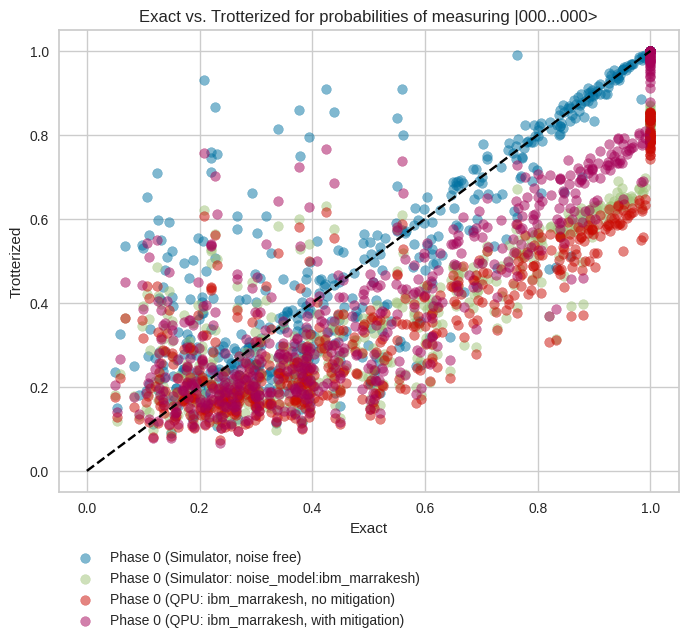

In [15]:
# Plot exact vs. Trotterized results
plt.figure(figsize=(8, 6))
plt.scatter(
    probs_phase0_exact_extracted,
    probs_phase0_sim_extracted,
    label=f"Phase 0 (Simulator, noise free)",
    alpha=0.5,
)
plt.scatter(
    probs_phase0_exact_extracted,
    probs_phase0_sim_noisy_extracted,
    label=f"Phase 0 (Simulator: noise_model:{backend_qpu_name})",
    alpha=0.5,
)
plt.scatter(
    probs_phase0_exact_extracted,
    probs_phase0_nmit_extracted,
    label=f"Phase 0 (QPU: {backend_qpu_name}, no mitigation)",
    alpha=0.5,
)
plt.scatter(
    probs_phase0_exact_extracted,
    probs_phase0_mit_extracted,
    label=f"Phase 0 (QPU: {backend_qpu_name}, with mitigation)",
    alpha=0.5,
)
# Plot the 1:1 line
plt.plot([0, 1], [0, 1], "--", color="black")
plt.xlabel("Exact")
plt.ylabel("Trotterized")
plt.legend(bbox_to_anchor=(0, -0.1), loc="upper left")
plt.title("Exact vs. Trotterized for probabilities of measuring |000...000>")
plt.show()

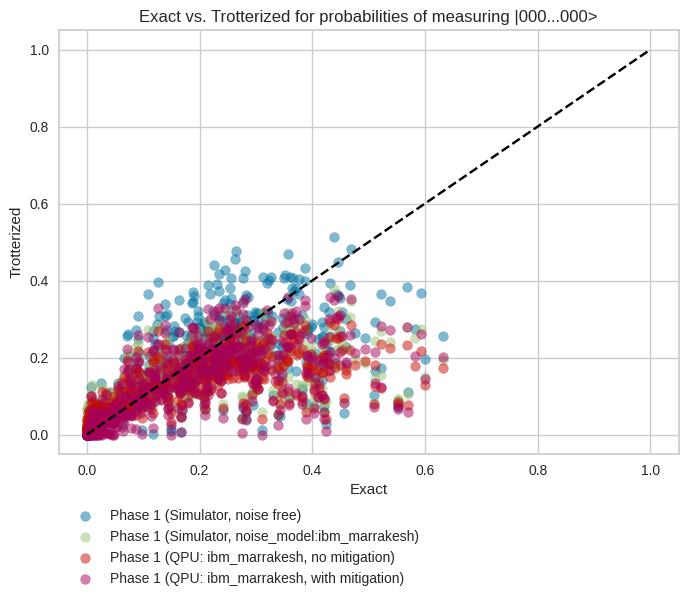

In [16]:
plt.scatter(
    probs_phase1_exact_extracted,
    probs_phase1_sim_extracted,
    label=f"Phase 1 (Simulator, noise free)",
    alpha=0.5,
)
plt.scatter(
    probs_phase1_exact_extracted,
    probs_phase1_sim_noisy_extracted,
    label=f"Phase 1 (Simulator, noise_model:{backend_qpu_name})",
    alpha=0.5,
)
plt.scatter(
    probs_phase1_exact_extracted,
    probs_phase1_nmit_extracted,
    label=f"Phase 1 (QPU: {backend_qpu_name}, no mitigation)",
    alpha=0.5,
)
plt.scatter(
    probs_phase1_exact_extracted,
    probs_phase1_mit_extracted,
    label=f"Phase 1 (QPU: {backend_qpu_name}, with mitigation)",
    alpha=0.5,
)
# Plot the 1:1 line
plt.plot([0, 1], [0, 1], "--", color="black")
plt.xlabel("Exact")
plt.ylabel("Trotterized")
plt.legend(bbox_to_anchor=(0, -0.1), loc="upper left")
plt.title("Exact vs. Trotterized for probabilities of measuring |000...000>")
plt.show()

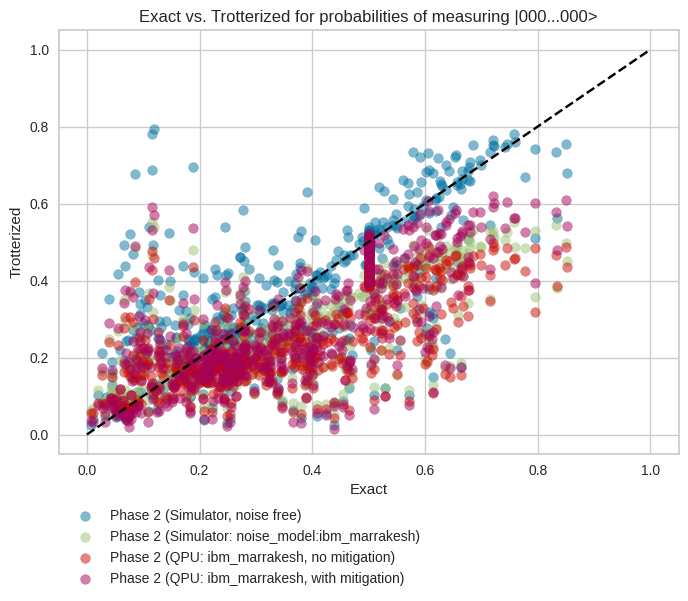

In [17]:
plt.scatter(
    probs_phase2_exact_extracted,
    probs_phase2_sim_extracted,
    label=f"Phase 2 (Simulator, noise free)",
    alpha=0.5,
)
plt.scatter(
    probs_phase2_exact_extracted,
    probs_phase2_sim_noisy_extracted,
    label=f"Phase 2 (Simulator: noise_model:{backend_qpu_name})",
    alpha=0.5,
)
plt.scatter(
    probs_phase2_exact_extracted,
    probs_phase2_nmit_extracted,
    label=f"Phase 2 (QPU: {backend_qpu_name}, no mitigation)",
    alpha=0.5,
)
plt.scatter(
    probs_phase2_exact_extracted,
    probs_phase2_mit_extracted,
    label=f"Phase 2 (QPU: {backend_qpu_name}, with mitigation)",
    alpha=0.5,
)
# Plot the 1:1 line
plt.plot([0, 1], [0, 1], "--", color="black")
plt.xlabel("Exact")

plt.ylabel("Trotterized")
plt.legend(bbox_to_anchor=(0, -0.1), loc="upper left")
plt.title("Exact vs. Trotterized for probabilities of measuring |000...000>")
plt.show()

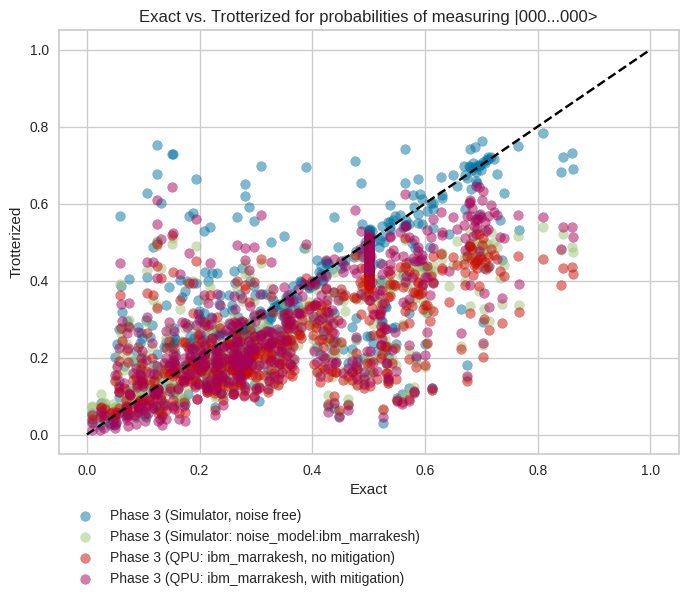

In [18]:
plt.scatter(
    probs_phase3_exact_extracted,
    probs_phase3_sim_extracted,
    label=f"Phase 3 (Simulator, noise free)",
    alpha=0.5,
)
plt.scatter(
    probs_phase3_exact_extracted,
    probs_phase3_sim_noisy_extracted,
    label=f"Phase 3 (Simulator: noise_model:{backend_qpu_name})",
    alpha=0.5,
)
plt.scatter(
    probs_phase3_exact_extracted,
    probs_phase3_nmit_extracted,
    label=f"Phase 3 (QPU: {backend_qpu_name}, no mitigation)",
    alpha=0.5,
)
plt.scatter(
    probs_phase3_exact_extracted,
    probs_phase3_mit_extracted,
    label=f"Phase 3 (QPU: {backend_qpu_name}, with mitigation)",
    alpha=0.5,
)
# Plot the 1:1 line
plt.plot([0, 1], [0, 1], "--", color="black")
plt.xlabel("Exact")
plt.ylabel("Trotterized")
plt.legend(bbox_to_anchor=(0, -0.1), loc="upper left")
plt.title("Exact vs. Trotterized for probabilities of measuring |000...000>")
plt.show()

## Regression

In [19]:
data_exact_df = pd.read_json(f"{path}/data_exact_df.json")

In [20]:
data_sim_df = pd.read_json(f"{path}/data_sim_df.json")

In [21]:
data_sim_noisy_df = pd.read_json(f"{path}/data_sim_noisy_df.json")

In [24]:
data_nmit_df = pd.read_json(f"{path}/data_qpu_nmit_df.json")
data_mit_df = pd.read_json(f"{path}/data_qpu_mit_df.json")

In [23]:
# For debugging
data_mit_df = data_exact_df

In [25]:
# Extract features which have overlap with data_mit_df (i.e. successful samples)
data_exact_df = data_exact_df[data_exact_df.index.isin(data_mit_df.sample_id)]

In [26]:
data_sim_df = data_sim_df[data_sim_df.index.isin(data_mit_df.sample_id)]

In [27]:
data_sim_noisy_df = data_sim_noisy_df[
    data_sim_noisy_df.index.isin(data_mit_df.sample_id)
]

In [28]:
data_nmit_df = data_nmit_df[data_nmit_df.index.isin(data_mit_df.sample_id)]

In [29]:
print("Exact")
display(data_exact_df)

Exact


,sample_id,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,...,f_5 Im,f_6 Re,f_6 Im,f_7 Re,f_7 Im,f_8 Re,f_8 Im,f_9 Re,f_9 Im,expected_value
0,0,1,0.900047,-0.332700,0.635283,-0.609494,0.287738,-0.779225,-0.058833,-0.806006,...,-0.683787,-0.546998,-0.445753,-0.638873,-0.156718,-0.610967,0.111648,-0.469065,0.308467,1.582990
1,1,1,0.850001,-0.412066,0.486014,-0.624517,0.111061,-0.559195,-0.082970,-0.302143,...,-0.041813,0.171595,0.054095,0.347926,-0.058373,0.353618,-0.281554,0.170391,-0.450303,0.453302
2,2,1,0.897816,-0.290876,0.640270,-0.483702,0.335499,-0.535950,0.076776,-0.469539,...,-0.336297,-0.184153,-0.182929,-0.204061,-0.041636,-0.176450,0.066488,-0.123502,0.132407,1.100555
3,3,1,0.898511,-0.195204,0.674128,-0.262616,0.479211,-0.205658,0.386657,-0.134370,...,-0.135303,0.303237,-0.201439,0.216790,-0.275604,0.119879,-0.319299,0.047756,-0.333527,1.057326
4,4,1,0.967097,0.126070,0.878896,0.225838,0.761707,0.284416,0.645852,0.303312,...,0.297480,0.498253,0.287541,0.473686,0.291132,0.468802,0.316601,0.469811,0.361831,2.430337
5,5,1,0.790331,-0.310000,0.355392,-0.317697,0.066869,-0.038508,0.094203,0.238947,...,0.276044,0.366651,0.104858,0.252579,-0.056992,0.060816,-0.048947,-0.032092,0.095503,1.390452
6,6,1,0.905174,0.392721,0.653416,0.691569,0.321942,0.844675,-0.011694,0.853602,...,0.750433,-0.522324,0.566294,-0.663532,0.321318,-0.700998,0.040540,-0.617745,-0.228622,5.624548
7,7,1,0.942251,-0.161082,0.798125,-0.274746,0.630302,-0.326757,0.488604,-0.334308,...,-0.318443,0.326877,-0.288385,0.293764,-0.252019,0.274444,-0.227292,0.240054,-0.229836,1.090109
8,8,1,0.865242,-0.157150,0.556035,-0.321777,0.248575,-0.423261,0.040529,-0.388326,...,-0.239837,-0.082493,-0.073372,-0.037057,0.030573,0.036677,0.045328,0.094292,-0.023382,8.392081
9,9,1,0.989869,0.082264,0.964050,0.164233,0.929583,0.241075,0.889556,0.309520,...,0.370312,0.803684,0.422234,0.757579,0.463264,0.705039,0.496501,0.648946,0.525904,1.481529


In [30]:
print("Simulator (noise free)")
display(data_sim_df)

Simulator (noise free)


,sample_id,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,...,f_5 Im,f_6 Re,f_6 Im,f_7 Re,f_7 Im,f_8 Re,f_8 Im,f_9 Re,f_9 Im,expected_value
0,0,1,0.890747,-0.340418,0.653977,-0.608250,0.448901,-0.691880,0.102500,-0.603386,...,-0.522857,0.015041,-0.349414,0.123541,-0.028373,-0.000551,0.146135,-0.065047,-0.056340,1.582990
1,1,1,0.841892,-0.436275,0.464319,-0.613212,0.102088,-0.557271,-0.075769,-0.311897,...,-0.040490,0.076783,0.049853,0.228299,-0.016907,0.201312,-0.113625,0.122259,-0.151665,0.453302
2,2,1,0.892087,-0.316763,0.665577,-0.493810,0.419008,-0.571773,0.156322,-0.552290,...,-0.350329,-0.142902,-0.083071,-0.089007,0.203430,0.029007,0.277037,0.036588,0.166707,1.100555
3,3,1,0.876956,-0.203302,0.611964,-0.262618,0.282231,-0.208038,0.050726,-0.011834,...,0.266642,-0.167560,0.508834,-0.050163,0.682708,0.138086,0.660986,0.248892,0.488607,1.057326
4,4,1,0.969888,0.120617,0.897305,0.232882,0.785099,0.309272,0.680538,0.398446,...,0.504160,0.401575,0.501942,0.278910,0.401557,0.219530,0.275921,0.281031,0.136737,2.430337
5,5,1,0.758443,-0.333806,0.411796,-0.373817,0.106899,-0.289388,0.000216,-0.120596,...,-0.023935,0.074007,0.078380,0.168818,0.069171,0.097179,-0.009642,-0.108648,-0.005793,1.390452
6,6,1,0.894535,0.407994,0.644662,0.696631,0.309126,0.823590,-0.056750,0.822590,...,0.627373,-0.457082,0.385426,-0.432905,0.106524,-0.367213,-0.029240,-0.177919,-0.132294,5.624548
7,7,1,0.929176,-0.165887,0.774306,-0.248118,0.544700,-0.314073,0.265984,-0.228373,...,-0.082463,-0.124251,0.166225,-0.184370,0.421555,-0.134989,0.654085,-0.031025,0.823341,1.090109
8,8,1,0.883759,-0.128461,0.513993,-0.177398,0.135094,-0.091256,-0.137390,0.128194,...,0.296822,-0.410403,0.355477,-0.405993,0.172006,-0.395918,-0.072533,-0.272051,-0.167226,8.392081
9,9,1,0.990719,0.080148,0.981350,0.140963,0.918787,0.244562,0.872827,0.317550,...,0.296369,0.681198,0.352258,0.571641,0.425103,0.529132,0.496274,0.453750,0.480819,1.481529


In [31]:
print("Simulator (noisy)")
display(data_sim_noisy_df)

Simulator (noisy)


,sample_id,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,...,f_5 Im,f_6 Re,f_6 Im,f_7 Re,f_7 Im,f_8 Re,f_8 Im,f_9 Re,f_9 Im,expected_value
0,0,0.810547,0.575937,-0.246050,0.403517,-0.386261,0.261516,-0.427338,0.075394,-0.350704,...,-0.345465,-0.032511,-0.207362,0.064772,-0.030160,0.019203,0.080336,-0.032110,-0.047208,1.582990
1,1,0.806641,0.545393,-0.250127,0.301104,-0.403566,0.029222,-0.334168,-0.048344,-0.181255,...,-0.016176,0.036379,0.020068,0.155778,-0.034436,0.093074,-0.042528,0.083400,-0.086494,0.453302
2,2,0.826172,0.545944,-0.163749,0.418076,-0.305743,0.222085,-0.355376,0.125887,-0.292125,...,-0.195379,-0.039805,-0.038923,-0.059309,0.105670,0.010788,0.136966,0.047667,0.077528,1.100555
3,3,0.802734,0.527040,-0.117608,0.366535,-0.182406,0.217182,-0.140288,-0.006846,0.012802,...,0.148278,-0.096026,0.329071,-0.023619,0.387252,0.096507,0.449209,0.169419,0.314206,1.057326
4,4,0.822266,0.585064,0.072361,0.548594,0.157497,0.535572,0.180538,0.450370,0.240574,...,0.289854,0.225006,0.309646,0.199933,0.265181,0.148743,0.172434,0.141841,0.103851,2.430337
5,5,0.818359,0.474944,-0.203745,0.210765,-0.232086,0.099739,-0.124089,-0.010731,-0.035645,...,-0.004940,0.078744,0.049403,0.069085,0.034684,0.021357,0.001610,-0.065772,0.011714,1.390452
6,6,0.812500,0.548481,0.249037,0.410436,0.415575,0.138955,0.479784,-0.046852,0.524824,...,0.370872,-0.260445,0.188905,-0.251253,0.087600,-0.200194,-0.026718,-0.094223,-0.053370,5.624548
7,7,0.820312,0.572505,-0.110922,0.482693,-0.167657,0.316325,-0.184472,0.156771,-0.132301,...,-0.046412,-0.069957,0.110990,-0.082662,0.266452,-0.087068,0.419848,-0.063245,0.512034,1.090109
8,8,0.807617,0.554231,-0.076515,0.347524,-0.131679,0.088571,-0.033132,-0.088783,0.070283,...,0.179629,-0.257201,0.198937,-0.267816,0.139548,-0.232371,-0.006666,-0.160664,-0.096567,8.392081
9,9,0.811523,0.594072,0.030654,0.588515,0.105371,0.578520,0.143134,0.512746,0.190762,...,0.200017,0.419797,0.206953,0.342648,0.281648,0.329464,0.278801,0.286145,0.311198,1.481529


In [32]:
print("no mitigation")
display(data_nmit_df)

print("mitigation")
display(data_mit_df)

no mitigation


,sample_id,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,...,f_5 Im,f_6 Re,f_6 Im,f_7 Re,f_7 Im,f_8 Re,f_8 Im,f_9 Re,f_9 Im,expected_value
0,0,1.000000,0.698605,-0.191447,0.496187,-0.455662,0.183712,-0.577192,-0.039272,-0.468980,...,-0.364586,0.010848,-0.298112,0.102501,-0.033579,0.022194,0.115016,-0.066647,-0.032982,1.582990
1,1,1.000000,0.620708,-0.448598,0.319000,-0.542007,0.025401,-0.463907,-0.106775,-0.231932,...,-0.043222,0.078922,0.006469,0.157730,-0.078284,0.132659,-0.111768,0.050319,-0.117042,0.453302
2,2,1.000000,0.715514,-0.254852,0.552146,-0.335842,0.333179,-0.438178,0.102717,-0.428553,...,-0.271363,-0.112127,-0.018227,-0.026703,0.179667,0.013006,0.211218,0.025707,0.124480,1.100555
3,3,1.000000,0.617536,-0.382785,0.456513,-0.324234,0.207110,-0.164642,0.019032,-0.010383,...,0.239846,-0.034809,0.440441,0.038112,0.575813,0.196626,0.521019,0.232194,0.399438,1.057326
4,4,1.000000,0.757966,0.073503,0.684904,0.220098,0.643325,0.231391,0.531377,0.340518,...,0.278479,0.449601,0.310480,0.314723,0.277722,0.226140,0.181272,0.201644,0.115553,2.430337
5,5,1.000000,0.612477,-0.383265,0.273124,-0.380916,0.082616,-0.195687,0.003812,-0.119248,...,-0.017001,0.060203,0.077957,0.138212,0.059456,0.091708,-0.029041,-0.088038,0.014604,1.390452
6,6,1.000000,0.746169,0.180590,0.568333,0.434447,0.297346,0.640753,-0.024949,0.640190,...,0.529347,-0.363817,0.237802,-0.322696,0.165024,-0.246813,-0.010341,-0.115735,-0.062819,5.624548
7,7,1.000000,0.717900,-0.149855,0.621389,-0.204645,0.446002,-0.245776,0.221690,-0.160332,...,-0.056576,-0.065852,0.151799,-0.106937,0.357979,-0.128886,0.485890,0.067069,0.642703,1.090109
8,8,0.971698,0.570665,-0.095398,0.335084,-0.130455,0.110506,-0.061736,-0.116423,0.055081,...,0.203187,-0.280317,0.197254,-0.293427,0.127550,-0.261757,-0.022427,-0.150475,-0.111967,8.392081
9,9,0.977928,0.686568,-0.117408,0.694063,-0.110391,0.663254,0.021641,0.643581,0.181374,...,0.250935,0.501289,0.239540,0.461510,0.152171,0.450626,0.232311,0.405641,0.207972,1.481529


mitigation


,sample_id,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,...,f_5 Im,f_6 Re,f_6 Im,f_7 Re,f_7 Im,f_8 Re,f_8 Im,f_9 Re,f_9 Im,expected_value
0,0,0.817871,0.518745,-0.141568,0.367911,-0.338811,0.135180,-0.428277,-0.028068,-0.346098,...,-0.270298,0.007645,-0.220835,0.075963,-0.025297,0.016834,0.084849,-0.048863,-0.025707,1.582990
1,1,0.814453,0.461733,-0.331257,0.236647,-0.404281,0.017191,-0.345326,-0.080502,-0.172694,...,-0.032370,0.058652,0.004415,0.116607,-0.059030,0.099257,-0.082916,0.035325,-0.084886,0.453302
2,2,0.808838,0.530716,-0.189418,0.413265,-0.249488,0.249173,-0.326867,0.076667,-0.314697,...,-0.201475,-0.084357,-0.012288,-0.021146,0.133028,0.009747,0.156810,0.020064,0.093465,1.100555
3,3,0.810303,0.458291,-0.284391,0.339301,-0.243750,0.154876,-0.123042,0.013805,-0.008541,...,0.179039,-0.026277,0.328032,0.028128,0.429892,0.144651,0.388870,0.172933,0.296538,1.057326
4,4,0.817139,0.562935,0.055702,0.510959,0.163421,0.478803,0.170389,0.394828,0.252122,...,0.205603,0.333180,0.230660,0.232778,0.205248,0.167258,0.133621,0.148898,0.085371,2.430337
5,5,0.836670,0.458652,-0.284936,0.204039,-0.281937,0.060046,-0.144632,0.002096,-0.088842,...,-0.011185,0.045242,0.057651,0.103736,0.043609,0.067794,-0.021447,-0.064994,0.011075,1.390452
6,6,0.840820,0.553741,0.132114,0.422065,0.322257,0.221065,0.475062,-0.021466,0.478059,...,0.393846,-0.269946,0.176498,-0.239036,0.122321,-0.184805,-0.005074,-0.086297,-0.046046,5.624548
7,7,0.834473,0.534020,-0.109662,0.461181,-0.151168,0.333148,-0.182770,0.165350,-0.119526,...,-0.042169,-0.049314,0.113873,-0.080229,0.267590,-0.096189,0.361717,0.051877,0.478724,1.090109
8,8,0.767578,0.423182,-0.069969,0.247380,-0.098554,0.081573,-0.046732,-0.086983,0.041078,...,0.151827,-0.208172,0.145816,-0.219164,0.094216,-0.195800,-0.018215,-0.110154,-0.084139,8.392081
9,9,0.770264,0.512701,-0.085287,0.517660,-0.081867,0.491381,0.016975,0.479002,0.136130,...,0.187196,0.367127,0.177916,0.344732,0.112995,0.335773,0.174584,0.301744,0.155969,1.481529


## Exact

In [33]:
train_size = 0.8
session_id = 42

In [34]:
s_exact = RegressionExperiment()
s_exact.setup(
    data=data_exact_df,
    target="expected_value",
    ignore_features=["sample_id", "norm"],
    train_size=train_size,
    session_id=session_id,
)

,Description,Value
0,Session id,42
1,Target,expected_value
2,Target type,Regression
3,Original data shape,"(56, 21)"
4,Transformed data shape,"(56, 20)"
5,Transformed train set shape,"(44, 20)"
6,Transformed test set shape,"(12, 20)"
7,Ignore features,2
8,Numeric features,19
9,Preprocess,True


In [ ]:
def create_model_and_plot(experiment: RegressionExperiment) -> None:
    # 実際の値 (expected_value) と予測値 (prediction_label)
    model = experiment.compare_models(turbo=True, sort="R2")
    experiment.tune_model(model, optimize="MSE", choose_better=True)

    # モデルの名前を取得
    model_name = model.__class__.__name__

    pred = experiment.predict_model(model)
    x = pred["expected_value"].values.reshape(-1, 1)  # サンプル数 x 1
    y = pred["prediction_label"].values

    # 回帰直線を計算
    linear_model = LinearRegression()
    linear_model.fit(x, y)
    slope = linear_model.coef_[0]
    intercept = linear_model.intercept_

    # プロット
    results = experiment.pull()
    r2 = results["R2"].values[0]
    mse = results["MSE"].values[0]
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, alpha=0.5, label=f"R2 = {r2:.2f}, MSE = {mse:.2f}")

    # 回帰直線を追加
    x_range = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
    plt.plot(
        x_range,
        linear_model.predict(x_range),
        color="red",
        label=f"Best fit line (y = {slope:.2f}x + {intercept:.2f})",
    )

    # Identity line
    plt.plot(
        [x.min(), x.max()], [x.min(), x.max()], "--", color="black", label="Identity"
    )

    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.legend()
    plt.title(f"Predicted vs Actual for {model_name}")
    plt.show()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.0266,0.0030,0.0437,0.9991,0.0153,0.0328,0.2940
br,Bayesian Ridge,0.1645,0.1646,0.2638,0.9838,0.0603,0.1420,0.1640
huber,Huber Regressor,0.3217,0.3193,0.4504,0.9483,0.0838,0.1996,0.1540
et,Extra Trees Regressor,1.3060,3.3557,1.7050,0.6168,0.3547,0.7525,0.0180
ridge,Ridge Regression,1.2931,3.4849,1.6762,0.5950,0.3624,1.2016,0.1610
rf,Random Forest Regressor,1.5184,3.9125,1.8425,0.4817,0.4238,1.0911,0.0220
knn,K Neighbors Regressor,1.5508,4.4263,1.9425,0.4780,0.4374,1.2223,0.0130
ada,AdaBoost Regressor,1.3850,3.6352,1.7238,0.4636,0.4113,1.2035,0.0110
omp,Orthogonal Matching Pursuit,1.7110,5.4169,2.1186,0.4084,0.4187,0.8893,0.1600
gbr,Gradient Boosting Regressor,1.4131,3.8392,1.8381,0.3787,0.4022,0.8269,0.0110


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0170,0.0004,0.0194,1.0000,0.0125,0.0419
1,0.0178,0.0010,0.0318,0.9999,0.0037,0.0075
2,0.0341,0.0021,0.0459,0.9999,0.0326,0.1755
3,0.0276,0.0023,0.0478,0.9996,0.0141,0.0105
4,0.0140,0.0005,0.0220,0.9999,0.0024,0.0024
5,0.0222,0.0011,0.0334,0.9998,0.0122,0.0190
6,0.0606,0.0110,0.1048,0.9991,0.0422,0.0421
7,0.0066,0.0001,0.0085,1.0000,0.0018,0.0019
8,0.0547,0.0110,0.1047,0.9935,0.0292,0.0261


Fitting 10 folds for each of 2 candidates, totalling 20 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,0.0230,0.0022,0.0468,0.9996,0.0091,0.0130


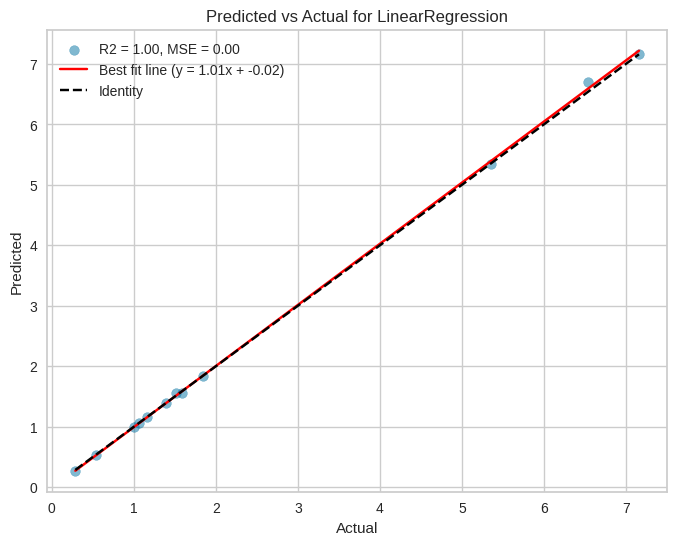

In [36]:
create_model_and_plot(s_exact)

## Trotter (Simulation, Noise free)

In [37]:
s_sim = RegressionExperiment()
s_sim.setup(
    data=data_sim_df,
    target="expected_value",
    ignore_features=["sample_id", "norm"],
    train_size=train_size,
    session_id=session_id,
)

,Description,Value
0,Session id,42
1,Target,expected_value
2,Target type,Regression
3,Original data shape,"(56, 21)"
4,Transformed data shape,"(56, 20)"
5,Transformed train set shape,"(44, 20)"
6,Transformed test set shape,"(12, 20)"
7,Ignore features,2
8,Numeric features,19
9,Preprocess,True


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,05:34:47
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Linear Regression


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,1.2528,2.8978,1.6488,0.5655,0.3332,0.5720,0.0180
ridge,Ridge Regression,1.3992,3.7387,1.7859,0.5209,0.3890,1.0050,0.0050
huber,Huber Regressor,1.1818,2.7010,1.4856,0.4969,0.3386,0.8246,0.0070
ada,AdaBoost Regressor,1.2673,4.0081,1.7416,0.4655,0.3427,0.7178,0.0110
gbr,Gradient Boosting Regressor,1.3069,3.8834,1.8099,0.4382,0.3541,0.5752,0.0110
omp,Orthogonal Matching Pursuit,1.6785,5.2216,2.0835,0.4228,0.4054,0.9075,0.0050
br,Bayesian Ridge,1.4086,3.8090,1.8247,0.4181,0.3968,0.9366,0.0060
rf,Random Forest Regressor,1.5527,4.7127,2.0019,0.3497,0.4149,0.9307,0.0220
knn,K Neighbors Regressor,1.7543,5.3751,2.1150,0.3323,0.4318,1.3126,0.0130
lr,Linear Regression,1.3814,3.3968,1.6795,0.2912,0.4108,1.5332,0.0050


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.7099,5.7315,2.3940,0.4603,0.5463,2.2148
1,1.2351,1.7332,1.3165,0.8947,0.3679,1.1360
2,2.7912,10.7043,3.2717,0.5777,0.5553,3.2460
3,0.8669,1.0106,1.0053,0.8077,0.2255,0.3442
4,1.4223,4.7870,2.1879,0.4421,0.2882,0.2279
5,0.8544,0.9676,0.9836,0.8229,0.3412,0.8293
6,1.6012,4.8359,2.1991,0.5963,0.4015,0.6517
7,1.0530,1.5254,1.2351,0.4770,0.2605,0.3424
8,1.1553,1.9133,1.3832,-0.1395,0.4728,1.0586


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,1.2100,2.3014,1.5170,0.5719,0.4053,0.8991


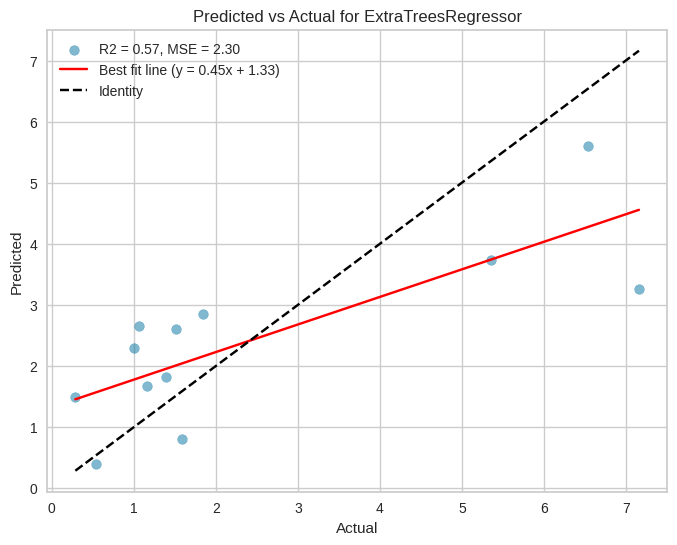

In [38]:
create_model_and_plot(s_sim)

## Trotter (Simulation, Noisy)

In [39]:
s_sim_noisy = RegressionExperiment()
s_sim_noisy.setup(
    data=data_sim_noisy_df,
    target="expected_value",
    ignore_features=["sample_id", "norm"],
    train_size=train_size,
    session_id=session_id,
)

,Description,Value
0,Session id,42
1,Target,expected_value
2,Target type,Regression
3,Original data shape,"(56, 21)"
4,Transformed data shape,"(56, 20)"
5,Transformed train set shape,"(44, 20)"
6,Transformed test set shape,"(12, 20)"
7,Ignore features,2
8,Numeric features,19
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,1.1516,2.9780,1.4761,0.6957,0.3648,0.6790,0.0070
ridge,Ridge Regression,1.4065,3.9658,1.7723,0.5709,0.3990,1.1637,0.0050
br,Bayesian Ridge,1.2963,3.4330,1.7067,0.5648,0.3581,0.8128,0.0050
et,Extra Trees Regressor,1.3470,3.3811,1.7608,0.4934,0.3568,0.7037,0.0180
ada,AdaBoost Regressor,1.2494,4.1260,1.7374,0.4886,0.3677,0.6781,0.0110
omp,Orthogonal Matching Pursuit,1.6869,5.3200,2.0952,0.4345,0.4002,0.8927,0.0050
rf,Random Forest Regressor,1.5792,4.8098,2.0124,0.3750,0.4442,1.1677,0.0230
lr,Linear Regression,1.6201,4.0964,1.9878,0.3689,0.4584,1.2668,0.0060
knn,K Neighbors Regressor,1.7695,5.4671,2.1601,0.3044,0.4310,1.0869,0.0130
par,Passive Aggressive Regressor,1.6798,4.6759,2.0424,0.2801,0.5034,1.2577,0.0060


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.6999,7.4589,2.7311,0.2976,0.5223,1.1864
1,0.5019,0.3552,0.5960,0.9784,0.2469,0.5410
2,2.1425,7.2859,2.6992,0.7126,0.3272,0.7380
3,0.7965,1.0694,1.0341,0.7965,0.1685,0.2238
4,2.2651,8.4350,2.9043,0.0169,0.6562,0.4395
5,0.3316,0.2039,0.4516,0.9627,0.1714,0.2422
6,1.3219,2.5807,1.6065,0.7846,0.4434,0.5811
7,0.5569,0.5201,0.7212,0.8217,0.1678,0.1849
8,0.8428,1.0649,1.0319,0.3658,0.3002,0.6293


Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,1.5679,3.5368,1.8806,0.3421,0.4378,1.2839


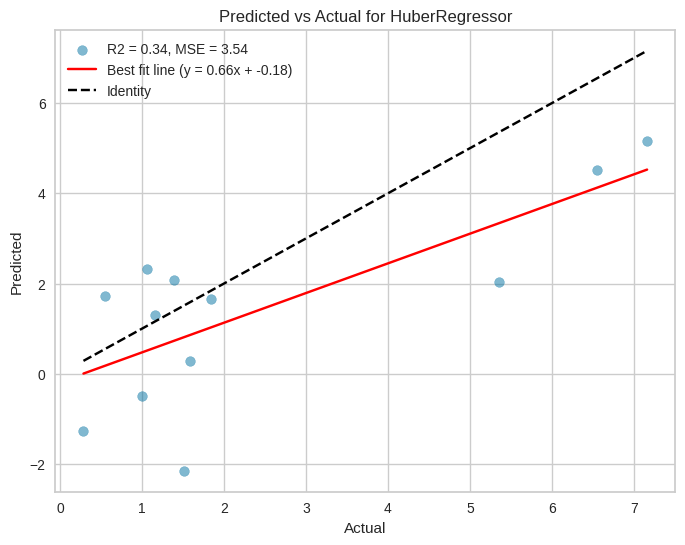

In [40]:
create_model_and_plot(s_sim_noisy)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,05:35:04
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.4737,4.7429,2.1778,0.5534,0.3810,0.6711
1,0.7866,0.8859,0.9412,0.9462,0.3058,0.7385
2,2.0745,5.9702,2.4434,0.7645,0.3942,1.7776
3,1.3657,2.6525,1.6286,0.4953,0.3346,0.5568
4,1.5768,5.1251,2.2639,0.4027,0.3143,0.2697
5,0.8579,1.0357,1.0177,0.8104,0.3099,0.6659
6,1.8233,5.9460,2.4384,0.5037,0.4549,0.7882
7,1.3205,3.3090,1.8191,-0.1346,0.3675,0.4946
8,1.1763,1.9824,1.4080,-0.1806,0.4210,0.5804


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.9875,7.4210,2.7242,0.3011,0.5871,2.0932
1,1.1043,1.7289,1.3149,0.8950,0.3876,1.2155
2,2.9325,12.0243,3.4676,0.5257,0.5681,3.2415
3,0.7220,0.8180,0.9044,0.8444,0.2658,0.4007
4,1.5463,5.8235,2.4132,0.3213,0.3257,0.2463
5,0.9263,1.2140,1.1018,0.7778,0.3837,0.9683
6,1.8660,6.6894,2.5864,0.4416,0.4635,0.7568
7,1.1512,2.2393,1.4964,0.2322,0.3200,0.4269
8,1.3051,2.1429,1.4639,-0.2763,0.4780,1.1364


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


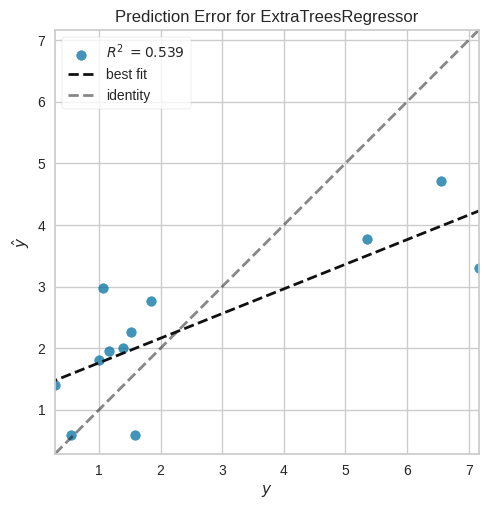

In [41]:
manual_model_sim_noisy = s_sim_noisy.create_model("et")
s_sim_noisy.tune_model(manual_model_sim_noisy, optimize="MSE", choose_better=True)
s_sim_noisy.plot_model(manual_model_sim_noisy, plot="error")

## Trotter (QPU, no mitigation)

,Description,Value
0,Session id,42
1,Target,expected_value
2,Target type,Regression
3,Original data shape,"(56, 21)"
4,Transformed data shape,"(56, 20)"
5,Transformed train set shape,"(44, 20)"
6,Transformed test set shape,"(12, 20)"
7,Ignore features,2
8,Numeric features,19
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ridge,Ridge Regression,1.5749,4.2848,1.9249,0.4811,0.4227,1.0801,0.0050
br,Bayesian Ridge,1.6078,4.3363,1.9673,0.4202,0.4247,0.9856,0.0060
omp,Orthogonal Matching Pursuit,1.7642,6.0397,2.2345,0.3604,0.4199,1.0214,0.0060
et,Extra Trees Regressor,1.5942,4.3619,2.0069,0.3274,0.3818,0.7277,0.0180
knn,K Neighbors Regressor,1.8250,6.1402,2.1991,0.3152,0.4594,1.3848,0.0090
rf,Random Forest Regressor,1.7244,5.7609,2.2865,0.2255,0.4467,0.9510,0.0220
par,Passive Aggressive Regressor,1.9394,5.7093,2.3548,0.1115,0.5665,1.2773,0.0060
ada,AdaBoost Regressor,1.6492,5.7013,2.2820,0.0493,0.4050,0.6688,0.0110
lightgbm,Light Gradient Boosting Machine,2.3730,9.1937,2.8056,0.0322,0.6517,2.8037,0.1370
huber,Huber Regressor,2.0366,6.7056,2.4804,-0.0138,0.5429,1.3453,0.0070


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.4201,5.6609,2.3793,0.4669,0.3951,0.5687
1,1.7005,3.5078,1.8729,0.7869,0.5364,1.6942
2,2.5886,13.9779,3.7387,0.4486,0.4669,1.5489
3,1.0886,1.5753,1.2551,0.7003,0.3709,0.5932
4,2.0133,6.0552,2.4607,0.2943,0.4649,0.4519
5,1.5294,2.6262,1.6205,0.5193,0.4647,1.2923
6,1.7260,5.2355,2.2881,0.5630,0.4204,0.7811
7,1.4612,2.9050,1.7044,0.0040,0.3538,0.5024
8,1.2895,1.7358,1.3175,-0.0338,0.5040,1.8107


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,1.3994,2.5814,1.6067,0.5198,0.4547,1.1841


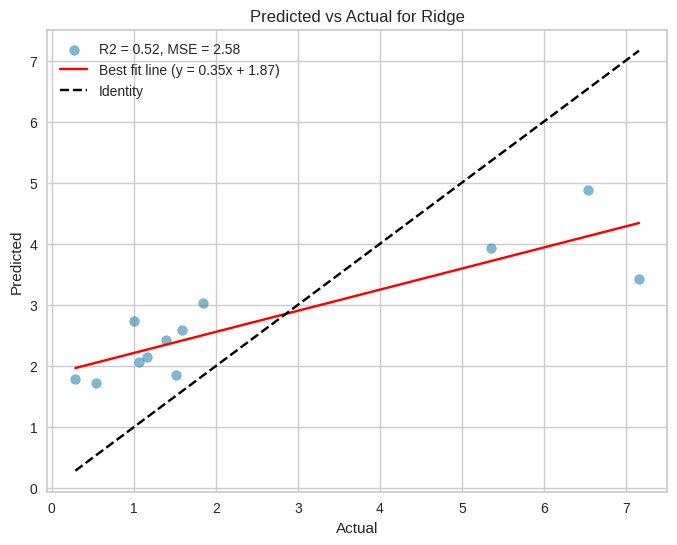

In [42]:
s_nmit = RegressionExperiment()
s_nmit.setup(
    data=data_nmit_df,
    target="expected_value",
    ignore_features=["sample_id", "norm"],
    train_size=train_size,
    session_id=session_id,
)
create_model_and_plot(s_nmit)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,05:35:54
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.3320,3.6839,1.9194,0.6531,0.3670,0.9725
1,1.4783,3.4782,1.8650,0.7887,0.3702,0.7260
2,2.6414,9.1427,3.0237,0.6393,0.4898,1.4352
3,1.4962,3.2142,1.7928,0.3884,0.3692,0.6490
4,1.2217,2.6135,1.6166,0.6954,0.2261,0.2394
5,1.0603,1.6193,1.2725,0.7036,0.2786,0.6007
6,1.9749,6.8022,2.6081,0.4322,0.4765,0.8070
7,2.1699,7.8369,2.7994,-1.6871,0.5039,0.7763
8,1.0281,1.6131,1.2701,0.0393,0.3890,0.5414


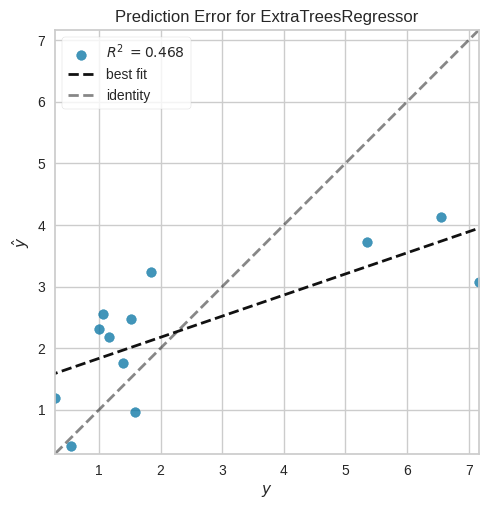

In [44]:
manual_model_nmit = s_nmit.create_model("et")
s_nmit.plot_model(manual_model_nmit, plot="error")

## Trotter (QPU, mitigation)

,Description,Value
0,Session id,42
1,Target,expected_value
2,Target type,Regression
3,Original data shape,"(56, 21)"
4,Transformed data shape,"(56, 20)"
5,Transformed train set shape,"(44, 20)"
6,Transformed test set shape,"(12, 20)"
7,Ignore features,2
8,Numeric features,19
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ridge,Ridge Regression,1.5717,4.4609,1.9341,0.4952,0.4333,1.2044,0.0050
br,Bayesian Ridge,1.5946,4.2923,1.9567,0.4286,0.4217,0.9515,0.0050
omp,Orthogonal Matching Pursuit,1.7666,6.0497,2.2379,0.3603,0.4207,1.0310,0.0060
et,Extra Trees Regressor,1.6225,4.6657,2.0655,0.3273,0.3910,0.7319,0.0180
knn,K Neighbors Regressor,1.8250,6.1402,2.1991,0.3152,0.4594,1.3848,0.0110
rf,Random Forest Regressor,1.6446,5.4543,2.2145,0.2728,0.4287,0.8835,0.0210
huber,Huber Regressor,1.8665,6.1142,2.3341,0.1968,0.5205,1.1913,0.0070
ada,AdaBoost Regressor,1.6046,5.4406,2.2081,0.1235,0.3905,0.7091,0.0110
lightgbm,Light Gradient Boosting Machine,2.3730,9.1937,2.8056,0.0322,0.6517,2.8037,0.1180
par,Passive Aggressive Regressor,2.1576,7.2547,2.6030,-0.1442,0.5831,1.3135,0.0050


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.4894,5.9671,2.4428,0.4381,0.4038,0.6377
1,1.8025,3.6224,1.9032,0.7799,0.5380,1.7716
2,2.8495,16.2377,4.0296,0.3595,0.5292,1.9449
3,1.0902,1.6882,1.2993,0.6788,0.4095,0.6520
4,1.8709,6.1204,2.4739,0.2867,0.4084,0.3889
5,1.4241,2.2460,1.4987,0.5889,0.4532,1.2674
6,1.8175,5.9452,2.4383,0.5037,0.4459,0.8128
7,1.5704,3.0034,1.7330,-0.0298,0.3654,0.5343
8,1.1745,1.4850,1.2186,0.1156,0.4733,1.6444


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,1.4756,2.7572,1.6605,0.4871,0.4752,1.2765


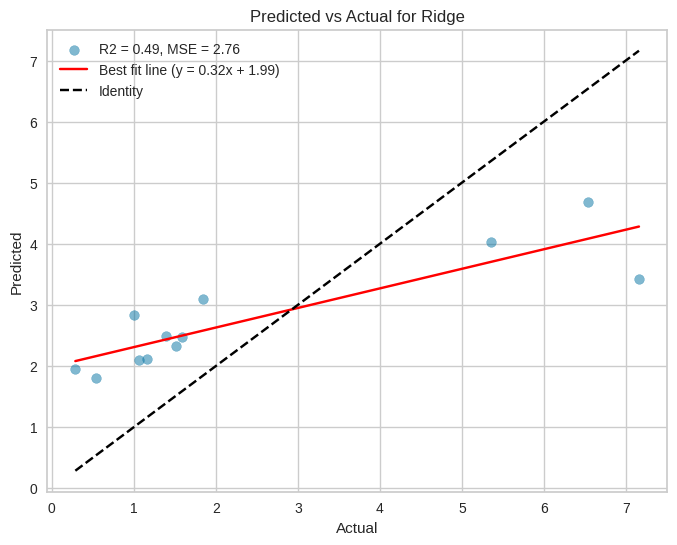

In [45]:
s_mit = RegressionExperiment()
s_mit.setup(
    data=data_mit_df,
    target="expected_value",
    ignore_features=["sample_id", "norm"],
    train_size=train_size,
    session_id=session_id,
)
create_model_and_plot(s_mit)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,05:37:47
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.4538,4.6045,2.1458,0.5664,0.4057,1.0135
1,1.3468,2.8595,1.6910,0.8263,0.3638,0.7406
2,2.8271,10.5237,3.2440,0.5849,0.5268,1.4908
3,1.5167,3.1579,1.7771,0.3991,0.3795,0.6775
4,1.3831,3.6243,1.9038,0.5776,0.2660,0.2668
5,0.9716,1.4622,1.2092,0.7324,0.2381,0.4872
6,2.1367,8.0161,2.8313,0.3309,0.5230,0.8887
7,1.9919,7.0487,2.6549,-1.4168,0.4752,0.7050
8,1.0201,1.5597,1.2489,0.0711,0.3757,0.5171


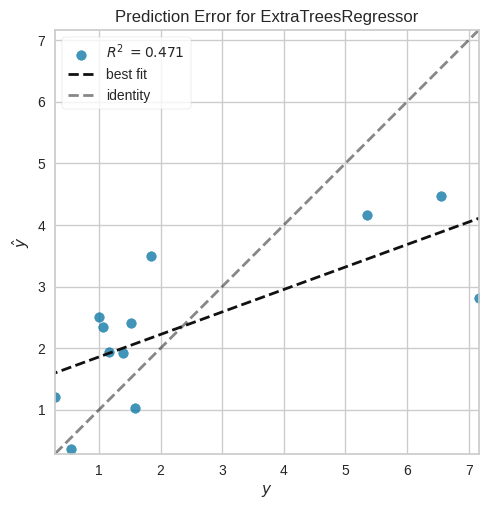

In [46]:
manual_model_mit = s_mit.create_model("et")
s_mit.plot_model(manual_model_mit, plot="error")